# DeleteMessages

Trong LangChain, bạn không chỉ có thể thêm tin nhắn mà còn có thể xóa chúng khi cần thiết. Công cụ `RemoveMessage` được sử dụng cho mục đích này.

Công cụ này gửi yêu cầu xóa cho một tin nhắn cụ thể. Việc xóa sau đó được xử lý theo các quy tắc `reducer` được định nghĩa trong `MessagesState`.

Về bản chất, `RemoveMessage` khởi tạo việc xóa, `reducer` xác định cách xử lý các yêu cầu đó và `MessagesState` đóng vai trò là hệ thống lưu trữ và quản lý tin nhắn.


## Building a Basic LangGraph

LangGraph cung cấp một cách mạnh mẽ để thiết kế quy trình làm việc tích hợp quản lý trạng thái tin nhắn và gọi công cụ. Phần này minh họa quy trình cơ bản để xây dựng một LangGraph.

**Các thành phần chính**
1. `MemorySaver`: Một đối tượng bộ nhớ để lưu các điểm kiểm tra (checkpoint), cho phép bạn lưu và khôi phục trạng thái hội thoại.
2. `ToolNode`: Một nút để thực thi các công cụ tùy chỉnh. Trong hướng dẫn này, nó bao gồm một công cụ `search` mô phỏng tìm kiếm trên web.
3. `MessagesState`: Lưu trữ và cập nhật trạng thái tin nhắn, đóng vai trò là trung tâm cho các quy trình làm việc dựa trên trạng thái.
4. `StateGraph`: Một đối tượng đồ thị định nghĩa quy trình làm việc dựa trên trạng thái, kiểm soát luồng thực thi giữa các nút và cạnh.
5. `should_continue`: Một hàm điều kiện xác định nút tiếp theo cần thực thi dựa trên trạng thái hiện tại của agent.

**Chi tiết quy trình làm việc chính**

**Định nghĩa và đăng ký công cụ:**
- Hàm `search` mô phỏng tìm kiếm trên web và trả về kết quả cho một truy vấn nhất định.
- Công cụ này sau đó được gói trong một `ToolNode` và tích hợp vào LangGraph.

**Khởi tạo và liên kết mô hình:**
- Khởi tạo một mô hình LLM, chẳng hạn như `ChatOpenAI`, và liên kết nó với các công cụ để đảm bảo chúng có thể được thực thi trong thời gian chạy.

**Định nghĩa quy trình làm việc:**
- `StateGraph` được sử dụng để định nghĩa quy trình làm việc bằng cách thêm các nút và kết nối chúng bằng các cạnh.
- Quy trình làm việc bắt đầu tại nút `START`. `agent` được thực thi đầu tiên, gọi các công cụ khi cần thiết, và sau đó quyền điều khiển quay trở lại agent.

**Kiểm soát luồng điều kiện:**
- Hàm `should_continue` kiểm tra trạng thái của tin nhắn cuối cùng để xác định xem một công cụ có nên được thực thi hay quy trình làm việc nên kết thúc.


In [2]:
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Initialize a memory object for checkpoint saving
memory = MemorySaver()


# Define a tool function mimicking a web search feature
@tool
def search(query: str):
    """Call to surf on the web."""
    return "Web search result: You can find the LangGraph tutorial at https://langchain-ai.github.io/langgraph/."


# Create a list of tools and initialize a tool node
tools = [search]
tool_node = ToolNode(tools)

# Initialize a model and bind tools. 
model = ChatOllama(model='qwen2.5:7b', temperature=0)
# model = ChatAnthropic(model="claude-3-5-sonnet-20240620") # if you use Claude
bound_model = model.bind_tools(tools)


# Determine the next execution node based on the conversation state
def should_continue(state: MessagesState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return END
    return "tool"


# Function to call the LLM model and handle its response
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Initialize a workflow graph based on the state
workflow = StateGraph(MessagesState)

# Add agent and action nodes
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# Set the starting point as the agent node
workflow.add_edge(START, "agent")

# Set conditional edges: define the execution flow after the agent node
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# Add an edge to return from the tool to the agent
workflow.add_edge("tool", "agent")

# Compile the final executable workflow including the checkpointer
app = workflow.compile(checkpointer=memory)

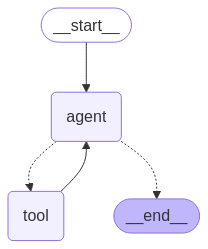

In [3]:
app

In [5]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={'thread_id': '1'})
input_message = HumanMessage(content="I like chocolate more than candy.")

for event in app.stream(input={"messages": [input_message]}, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

I like chocolate more than candy.
================================== Ai Message ==================================

That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.

Do you have any favorite types of chocolate or specific brands that you particularly enjoy?


In [7]:
snapshot = app.get_state(config=config)
snapshot.next

()

Đoạn mã sau, `for event in app.stream({"messages": [input_message]}, config, stream_mode="values")`, hoạt động như sau:

1.  **Gọi `app.stream()`:**
    * Điều này khởi tạo luồng công việc và truyền trực tiếp từng sự kiện.
    * Tham số:
        * `{"messages": [input_message]}`: Đặt tin nhắn ban đầu cho luồng công việc.
        * `config`: Chứa các giá trị cấu hình, bao gồm `thread_id` được đặt thành `"1"`.
        * `stream_mode="values"`: Chỉ định chế độ truyền trực tuyến dựa trên giá trị.

2.  **Hành vi vòng lặp:**
    * Vòng lặp lặp qua từng sự kiện được tạo bởi luồng công việc.
    * Chi tiết sự kiện:
        * `event["messages"][-1]`: Truy xuất tin nhắn gần đây nhất.
        * `pretty_print()`: In tin nhắn được truy xuất.

Các chế độ truyền trực tuyến chính của `app.stream()`:

1.  **Chế độ `values`**
    * Chế độ này nhận toàn bộ trạng thái của đồ thị sau mỗi lần thực thi nút.
    * Phù hợp để giám sát trạng thái cơ bản.
    * **Ví dụ:** Nhận phản hồi hoàn chỉnh từ LLM sau khi hoàn thành phản hồi.

2.  **Chế độ `updates`**
    * Chế độ này chỉ nhận các thay đổi được thực hiện đối với trạng thái sau mỗi lần thực thi nút.
    * Hữu ích cho việc quản lý trạng thái hiệu quả.
    * **Ví dụ:** Chỉ nhận nội dung mới được thêm so với trạng thái trước đó.

3.  **Chế độ `messages`**
    * Chế độ này cung cấp thông tin chi tiết, thời gian thực nhất.
    * Lý tưởng cho các ứng dụng thời gian thực, chẳng hạn như chatbot.
    * **Ví dụ:** Quan sát "quá trình suy nghĩ" từng bước của LLM trong thời gian thực. Ví dụ: "Thinking..." → "Chocolate is..." → "a delicious snack."


In [8]:
# Follow-up question execution
input_message = HumanMessage(content="What is my favorite snack?")

# Process the second message in stream mode and print the response
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

To determine your favorite snack, I would need a bit more information about what snacks you typically enjoy. However, based on the statement "I like chocolate more than candy," it seems likely that your favorite snack might be something involving chocolate.

Here are some possibilities:

1. **Chocolate Bar**: A classic choice with various flavors and brands.
2. **Dark Chocolate**: Known for its rich, complex flavor.
3. **Milk Chocolate**: Often preferred for its smoother taste.
4. **White Chocolate**: While not technically a cocoa-based product, it can be quite delightful.
5. **Chocolate Chips or Bites**: Useful in baking or as a quick snack.
6. **Hot Chocolate**: A comforting drink that can also be enjoyed as a snack.

If you have any specific preferences or past experiences with snacks, feel free

In [9]:
# Step-by-Step Status Check
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

I like chocolate more than candy.
================================== Ai Message ==================================

That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.

Do you have any favorite types of chocolate or specific brands that you particularly enjoy?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

To determine your favorite snack, I would need a bit more information about what snacks you typically enjoy. However, based on the statement "I like chocolate more than candy," it se

### Deleting Messages

Có hai phương pháp chính để xóa tin nhắn trong một quy trình làm việc LangGraph: **Xóa thủ công (Manual Deletion)** và **Xóa động (Dynamic Deletion)**. Hãy cùng xem xét kỹ hơn từng phương pháp.


## Manual Deletion of Messages

Phần này trình bày cách thủ công truy xuất nhật ký tin nhắn từ quy trình làm việc LangGraph, xóa các tin nhắn cụ thể và sau đó cập nhật trạng thái của đồ thị. Quy trình này cho phép quản lý tin nhắn hiệu quả và thao tác bản ghi cuộc trò chuyện.

**Các bước chính để Xóa thủ công (Manual Deletion)**
1.  **Truy xuất tin nhắn (Message Retrieval):**
    -   Sử dụng phương thức `app.get_state(config)` để trích xuất danh sách tin nhắn từ trạng thái hiện tại.
    -   Sử dụng phương thức `pretty_print()` để hiển thị từng tin nhắn ở định dạng thân thiện với người dùng.

2.  **Xóa tin nhắn (Message Deletion):**
    -   Sử dụng đối tượng `RemoveMessage`, chỉ định ID của tin nhắn cần xóa.
    -   Ví dụ mã minh họa việc xóa tin nhắn đầu tiên trong mảng.

3.  **Cập nhật trạng thái (State Update):**
    -   Sử dụng phương thức `app.update_state(config, ...)` để áp dụng việc xóa và cập nhật trạng thái của đồ thị.
    -   Sau khi cập nhật, truy xuất và hiển thị lại danh sách tin nhắn để xác minh việc xóa.

**Luồng mã (Code Flow)**
1.  **Tin nhắn được lưu trữ đầu ra (Output Stored Messages):**
    -   Truy xuất các tin nhắn từ trạng thái hiện tại bằng cách sử dụng `messages = app.get_state(config).values["messages"]`.
    -   Lặp qua danh sách `messages` và in từng tin nhắn để xem lại lịch sử cuộc trò chuyện hiện tại.

2.  **Xóa một tin nhắn cụ thể (Delete a Specific Message):**
    -   Sử dụng `RemoveMessage(id=messages[0].id)` để tạo yêu cầu xóa cho tin nhắn đầu tiên.
    -   Cập nhật trạng thái của đồ thị bằng cách sử dụng `app.update_state(config, ...)` để phản ánh việc xóa.

3.  **Tin nhắn được cập nhật đầu ra (Output Updated Messages):**
    -   Sau khi cập nhật trạng thái, truy xuất danh sách tin nhắn được cập nhật và in nó để xác nhận việc xóa.


In [10]:
# Extracting Message List in App State and Viewing Saved Conversation History
messages = app.get_state(config).values["messages"]

for message in messages:
    message.pretty_print()

================================ Human Message =================================

I like chocolate more than candy.
================================== Ai Message ==================================

That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.

Do you have any favorite types of chocolate or specific brands that you particularly enjoy?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

To determine your favorite snack, I would need a bit more information about what snacks you typically enjoy. However, based on the statement "I like chocolate more than candy," it se

In [11]:
from langchain_core.messages import RemoveMessage

# Remove the First Message from the Message Array by ID and Update the App State
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

# Extracting Message List from App State and Retrieving Saved Conversation History
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.

Do you have any favorite types of chocolate or specific brands that you particularly enjoy?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

To determine your favorite snack, I would need a bit more information about what snacks you typically enjoy. However, based on the statement "I like chocolate more than candy," it seems likely that your favorite snack might be something involving chocolate.

Here are some possibilities:

1. **Choc

## Dynamic Deletion of Messages

Chức năng xóa động (Dynamic deletion) tự động hóa quá trình xóa các tin nhắn cũ hơn trong quá trình thực thi luồng công việc (workflow execution), đảm bảo rằng chỉ những tin nhắn gần đây nhất được giữ lại.

**Các Thành phần Chính cho Xóa Động**

1.  `delete_messages(state: dict) -> dict`:
    -   Hàm này triển khai logic để xóa các tin nhắn cũ khi kiểm tra xem số lượng tin nhắn có vượt quá giới hạn cụ thể (ví dụ: 3) hay không. Nó chỉ giữ lại những tin nhắn mới nhất.

2.  `should_continue(state: dict) -> str`:
    -   Hàm điều kiện này xác định nút tiếp theo để thực thi dựa trên trạng thái hiện tại.
    -   Nếu không có lệnh gọi hàm (function call) trong các tin nhắn hiện tại, luồng công việc sẽ chuyển đến nút `delete_messages`. Nếu có lệnh gọi hàm, luồng công việc sẽ chuyển đến nút `action`.

3.  `StateGraph`: Định nghĩa luồng công việc dựa trên trạng thái, kết nối các nút `agent`, `action` và `delete_messages` với các cạnh (edges) thích hợp.

**Chi tiết Chính**

**Quản lý Tin nhắn (Message Management):**
-   Hàm `delete_messages` quản lý trạng thái tin nhắn bằng cách xóa các tin nhắn cũ hơn trong các cuộc trò chuyện kéo dài, do đó duy trì hiệu quả bộ nhớ.

**Kiểm soát Luồng Điều kiện (Conditional Flow Control):**
-   Hàm `should_continue` kiểm tra trạng thái của tin nhắn cuối cùng để xác định xem có cần lệnh gọi công cụ (tool call) hay không. Điều này xác định nút tiếp theo trong luồng thực thi.

**Định nghĩa Luồng Công việc (Workflow Definition):**
-   `StateGraph` định nghĩa luồng công việc bằng cách thêm các nút cho `agent`, `action` và `delete_messages`.
-   Mỗi nút được cấu hình để tuân theo luồng thích hợp dựa trên trạng thái và điều kiện.

**Tích hợp Điểm Kiểm tra Bộ nhớ (Memory Checkpoint Integration):**
-   Đối tượng `MemorySaver` cho phép lưu và khôi phục các điểm kiểm tra (checkpoints), cho phép biên dịch và tiếp tục luồng công việc liền mạch.


In [12]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END


# If the number of messages exceeds 3, delete older messages and retain only the latest ones
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# Logic to determine the next execution node based on the message state
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # Execute the message deletion function if no tool calls are present
    if not last_message.tool_calls:
        return "delete_messages"
    # Execute an action if tool calls are present
    return "action"


# Define the workflow graph based on the message state
workflow = StateGraph(MessagesState)

# Add agent and action nodes
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Add the message deletion node
workflow.add_node(delete_messages)

# Connect the start node to the agent node
workflow.add_edge(START, "agent")

# Control flow between nodes by adding conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# Connect the action node back to the agent node
workflow.add_edge("action", "agent")

# Connect the message deletion node to the end node
workflow.add_edge("delete_messages", END)

# Compile the workflow using a memory checkpoint
app = workflow.compile(checkpointer=memory)

**Process Flow**

1.  Quy trình làm việc bắt đầu tại node `START` và thực thi node `agent`.
2.  Hàm `should_continue` sau đó xác định node tiếp theo dựa trên trạng thái hiện tại:
    * Nếu không có lời gọi hàm (function call) nào trong các tin nhắn, quy trình làm việc chuyển đến node `delete_messages`.
    * Nếu có lời gọi hàm, quy trình làm việc chuyển đến node `action`.
3.  Mỗi node chuyển sang đường dẫn thực thi tiếp theo dựa trên các điều kiện được xác định.
4.  Node `delete_message` sau đó kết nối với node `END`, kết thúc nhánh đó của quy trình làm việc.


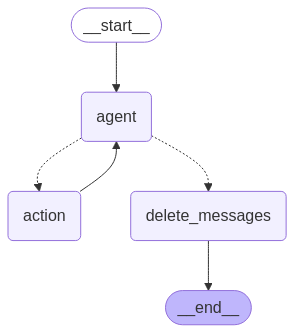

In [15]:
# Dynamic Deletion Visualization
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
# Import the HumanMessage class for LangChain message processing
from langchain_core.messages import HumanMessage

# Initialize a configuration object with a thread ID
config = {"configurable": {"thread_id": "2"}}

# Perform the first query
input_message = HumanMessage(content="I like chocolate more than candy.")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', 'I like chocolate more than candy.')]
[('human', 'I like chocolate more than candy.'), ('ai', "That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.\n\nDo you have any favorite types of chocolate or specific brands that you particularly enjoy?")]


In [17]:
# Perform the second query
input_message = HumanMessage(content="What is my favorite snack?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', 'I like chocolate more than candy.'), ('ai', "That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.\n\nDo you have any favorite types of chocolate or specific brands that you particularly enjoy?"), ('human', 'What is my favorite snack?')]
[('human', 'I like chocolate more than candy.'), ('ai', "That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.\n\nDo you have any favorite types of chocolate or specific brands that you 

In [18]:
# Extract and save the message list from the app state
messages = app.get_state(config).values["messages"]

# Return the message list
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

That's great! Chocolate and candy can both be delicious treats in their own ways. While they share some similarities, chocolate often has a richer, more complex flavor profile that many people enjoy. If you find yourself leaning towards chocolate over candy, it might be because of its depth of taste or the way it melts in your mouth.

Do you have any favorite types of chocolate or specific brands that you particularly enjoy?
================================ Human Message =================================

What is my favorite snack?
================================== Ai Message ==================================

To determine your favorite snack, I would need a bit more information about what snacks you typically enjoy. However, based on the statement "I like chocolate more than candy," it seems likely that your favorite snack might be something involving chocolate.

Here are some possibilities:

1. **Choc